In [535]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

In [536]:
run ../util/setupConsole

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [537]:
# low and high temps for gdd/kdd calcs, taken from Butler, et al, 2015, ERL
t_low = 9
t_high = 29

crop = 'Maize'
wxData = 'era5'

yieldDataOld = True

tempYearRange = [1981, 2018]
if yieldDataOld:
    yieldYearRange = [1981, 2008]
else:
    yieldYearRange = [1981, 2013]
yearRange = np.intersect1d(np.arange(tempYearRange[0], tempYearRange[1]+1), np.arange(yieldYearRange[0], yieldYearRange[1]+1))

In [538]:
# load gdd/kdd from cpc temperature data
with gzip.open('%s/kdd-%s-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'rb') as f:
    kdd = pickle.load(f)

with gzip.open('%s/gdd-%s-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'rb') as f:
    gdd = pickle.load(f)

with gzip.open('%s/gdd-kdd-lat-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    tempLat = pickle.load(f)

with gzip.open('%s/gdd-kdd-lon-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    tempLon = pickle.load(f)


In [539]:
maizeYield = []
for year in range(yieldYearRange[0],yieldYearRange[1]+1):
    
    if yieldDataOld:
        curMaizeYield = xr.open_dataset('%s/deepak/Maize_yield/Maize_areaweightedyield_%d.nc'%(dataDirDiscovery, year), decode_cf=False)
    else:
        curMaizeYield = xr.open_dataset('%s/deepak/Maize_yield_1970_2013/Maize_areaweightedyield_%d_ver12b.nc'%(dataDirDiscovery, year), decode_cf=False)
    
    curMaizeYield['time'] = [year]
    if len(maizeYield) == 0:
        maizeYield = curMaizeYield
    else:
        maizeYield = xr.concat([maizeYield, curMaizeYield], dim='time')
    
maizeYield.load()

<xarray.Dataset>
Dimensions:    (latitude: 360, level: 1, longitude: 720, time: 28)
Coordinates:
  * level      (level) float64 1.0
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * time       (time) int64 1981 1982 1983 1984 1985 ... 2005 2006 2007 2008
Data variables:
    Data       (time, level, latitude, longitude) float64 nan nan ... nan nan

In [540]:
# flip latitude axis so top is +90
if not yieldDataOld:
    latDeepak = np.flipud(maizeYield.latitude)
else:
    latDeepak = maizeYield.latitude
lonDeepak = np.roll(maizeYield.longitude, int(len(maizeYield.longitude)/2), axis=0)
lonDeepak[lonDeepak<0] += 360
maizeYield['Data'] = maizeYield.Data.transpose('latitude', 'longitude', 'time', 'level')
if not yieldDataOld:
    data = np.roll(np.flip(maizeYield['Data'], axis=0), int(len(lonDeepak)/2), axis=1)
else:
    data = np.roll(maizeYield['Data'], int(len(lonDeepak)/2), axis=1)

In [541]:
maizeYield['latitude'] = latDeepak
maizeYield['longitude'] = lonDeepak
maizeYield['Data'] = (('latitude', 'longitude', 'time'), np.squeeze(data))

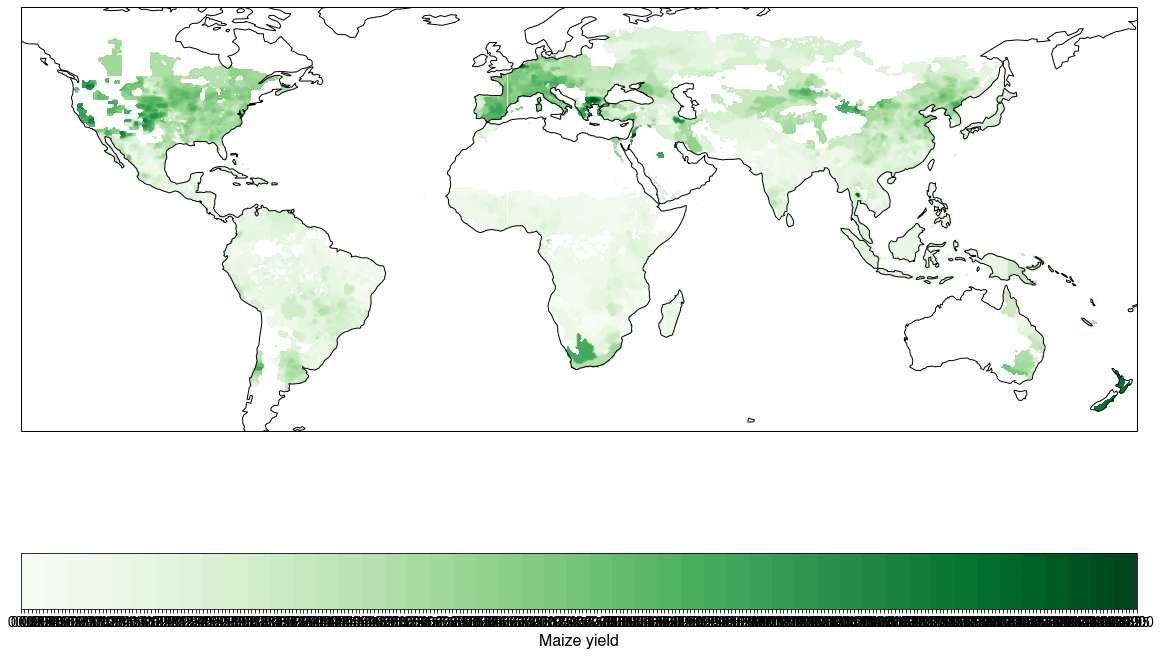

In [542]:
cRange=[0, 15]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(maizeYield.Data[:,:,10], cRange[0], cRange[1]), cmap='Greens', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .05))
cbar.set_label('Maize yield')
ax.coastlines()

In [543]:
kdd = kdd[:, :, 0:maizeYield.Data.shape[2]]
gdd = gdd[:, :, 0:maizeYield.Data.shape[2]]

In [544]:
maizeTrends = np.full([len(latDeepak), len(lonDeepak)], np.nan)

for xlat in range(len(latDeepak)):
    for ylon in range(len(lonDeepak)):
        y = np.squeeze(maizeYield.Data.values[xlat, ylon, :])
        
        if len(np.where(np.isnan(y))[0]) == 0:
            X = sm.add_constant(range(len(y)))
            mdl = sm.OLS(y, X).fit()
            maizeTrends[xlat, ylon] = mdl.params[1]
        

In [545]:
# calculate gdd and kdd trends from already-loaded cpc tmax and tmin data

if os.path.isfile('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1])) and os.path.isfile('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1])):
    with gzip.open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'rb') as f:
        kddTrends = pickle.load(f)

    with gzip.open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'rb') as f:
        gddTrends = pickle.load(f)
else:
    gddTrends = np.full([gdd.shape[0], gdd.shape[1]], np.nan)
    kddTrends = np.full([kdd.shape[0], kdd.shape[1]], np.nan)

    for x in range(gddTrends.shape[0]):
        for y in range(gddTrends.shape[1]):
            nn = np.where(~np.isnan(gdd[x, y, :]))[0]
            if len(nn) == gdd.shape[2]:
                X = sm.add_constant(range(gdd.shape[2]))
                mdl = sm.OLS(gdd[x, y, :], X).fit()
                gddTrends[x, y] = mdl.params[1]

            nn = np.where(~np.isnan(kdd[x, y, :]))[0]
            if len(nn) == kdd.shape[2]:
                X = sm.add_constant(range(kdd.shape[2]))
                mdl = sm.OLS(kdd[x, y, :], X).fit()
                kddTrends[x, y] = mdl.params[1]

    # if a grid cell has no gdd/kdds, trend will be exactly 0 - set to nan
    kddTrends[kddTrends == 0] = np.nan
    gddTrends[gddTrends == 0] = np.nan
    
    with gzip.open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'wb') as f:
        pickle.dump(kddTrends, f)

    with gzip.open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'wb') as f:
        pickle.dump(gddTrends, f)


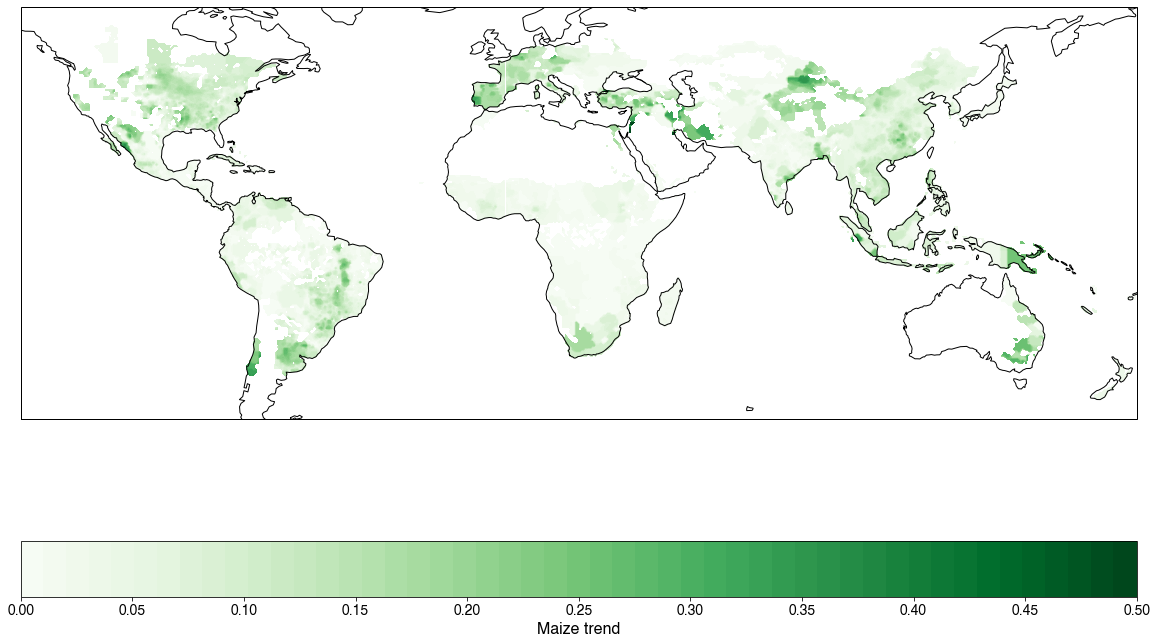

In [546]:
cRange=[0, .5]
f = plt.figure(figsize=(20,15))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(maizeTrends, cRange[0], cRange[1]), cmap='Greens', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .05))
cbar.set_label('Maize trend')
ax.coastlines()

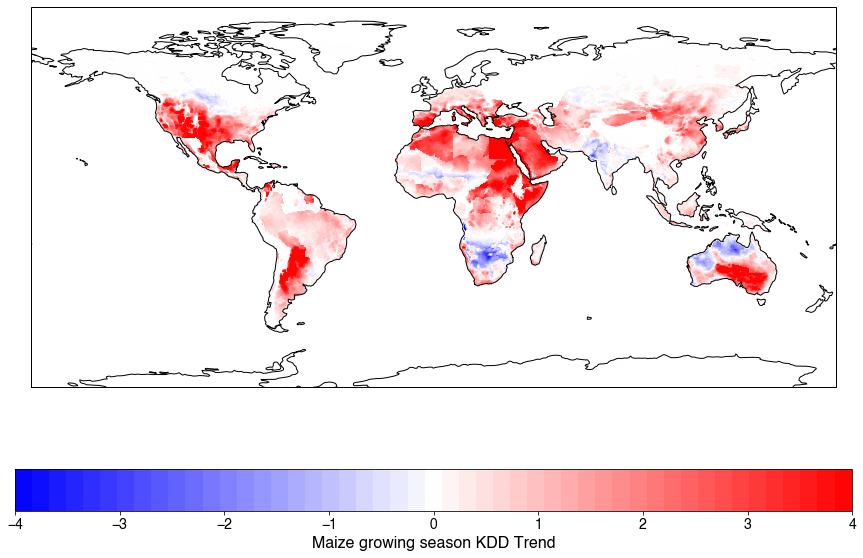

In [547]:
cRange=[-4, 4]
f = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(tempLon, tempLat, np.clip(kddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 1))
cbar.set_label('%s growing season KDD Trend'%crop)
ax.coastlines()

In [ ]:
yieldKddCoef = np.full([gdd.shape[0], gdd.shape[1]], np.nan)
yieldGddCoef = np.full([gdd.shape[0], gdd.shape[1]], np.nan)

for xlat in range(yieldKddCorr.shape[0]):
    if xlat%50==0:print(xlat)
    for ylon in range(yieldKddCorr.shape[1]):
        k = kdd[xlat, ylon, :]
        g = gdd[xlat, ylon, :]
        
        # find closest yield
        indLat = np.where(abs(tempLat[xlat]-latDeepak) == np.nanmin(abs(tempLat[xlat]-latDeepak)))[0][0]
        indLon = np.where(abs(tempLon[ylon]-lonDeepak) == np.nanmin(abs(tempLon[ylon]-lonDeepak)))[0][0]
        y = maizeYield.Data.values[indLat, indLon, :]

        ptMaxDeepak = (-1, -1)
        ptCurDeepak = (-1, -1)
        for i, val in enumerate(y):
            # start sequence
            if ~np.isnan(val) and ptCurDeepak[0] == -1:
                ptCurDeepak = (i, -1)
            #end sequence
            elif (np.isnan(val) and ptCurDeepak[0] >= 0):
                ptCurDeepak = (ptCurDeepak[0], i)
                if ptCurDeepak[1]-ptCurDeepak[0] > ptMaxDeepak[1]-ptMaxDeepak[0] or ptMaxDeepak == (-1, -1):
                    ptMaxDeepak = ptCurDeepak
                ptCurDeepak = (-1, -1)
            # reached end of sequence
            elif i >= len(y)-1 and ptCurDeepak[0] >= 0:
                ptCurDeepak = (ptCurDeepak[0], i)
                if ptCurDeepak[1]-ptCurDeepak[0] > ptMaxDeepak[1]-ptMaxDeepak[0] or ptMaxDeepak == (-1, -1):
                    ptMaxDeepak = ptCurDeepak
        
        if ptMaxDeepak[1]-ptMaxDeepak[0]+1 > 20 and np.nansum(k) > 0 and np.nansum(g) > 0:
            data = {'GDD':scipy.signal.detrend(g[ptMaxDeepak[0]:ptMaxDeepak[1]]), \
                    'KDD':scipy.signal.detrend(k[ptMaxDeepak[0]:ptMaxDeepak[1]]), \
                    'Yield':scipy.signal.detrend(y[ptMaxDeepak[0]:ptMaxDeepak[1]])}

            df = pd.DataFrame(data, \
                              columns=['GDD', 'KDD', \
                                       'Yield'])
            mdl = smf.ols(formula='Yield ~ GDD + KDD', data=df).fit()
            yieldGddCoef[xlat, ylon] = mdl.params['GDD']
            yieldKddCoef[xlat, ylon] = mdl.params['KDD']

0
50
100
150
200
250
300


In [ ]:
cRange=[-.01, .01]
f = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(yieldGddCoef, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 1))
cbar.set_label('%s growing season KDD Trend'%crop)
ax.coastlines()

In [ ]:
kddAgg = []
gddAgg = []
yieldAgg = []

for xlat in range(100, 110):#kdd.shape[0]):
    for ylon in range(540, 560):#kdd.shape[1]):
        curKdd = kdd[xlat, ylon, :]
        curGdd = gdd[xlat, ylon, :]
        curYield = maizeYield.Data.values[xlat, ylon, :]
        
        ptMaxDeepak = (-1, -1)
        ptCurDeepak = (-1, -1)
        for i, val in enumerate(curYield):
            # start sequence
            if ~np.isnan(val) and ptCurDeepak[0] == -1:
                ptCurDeepak = (i, -1)
            #end sequence
            elif (np.isnan(val) and ptCurDeepak[0] >= 0):
                ptCurDeepak = (ptCurDeepak[0], i)
                if ptCurDeepak[1]-ptCurDeepak[0] > ptMaxDeepak[1]-ptMaxDeepak[0] or ptMaxDeepak == (-1, -1):
                    ptMaxDeepak = ptCurDeepak
                ptCurDeepak = (-1, -1)
            # reached end of sequence
            elif i >= len(curYield)-1 and ptCurDeepak[0] >= 0:
                ptCurDeepak = (ptCurDeepak[0], i)
                if ptCurDeepak[1]-ptCurDeepak[0] > ptMaxDeepak[1]-ptMaxDeepak[0] or ptMaxDeepak == (-1, -1):
                    ptMaxDeepak = ptCurDeepak
        
        if ptMaxDeepak[1]-ptMaxDeepak[0]+1 >= 20:
            curKdd = curKdd[ptMaxDeepak[0]:ptMaxDeepak[1]]
            curGdd = curGdd[ptMaxDeepak[0]:ptMaxDeepak[1]]
            curYield = curYield[ptMaxDeepak[0]:ptMaxDeepak[1]]

            curKdd = scipy.signal.detrend(curKdd) 
#             curK /= np.linalg.norm(curK)
            curGdd = scipy.signal.detrend(curGdd)
#             curG /= np.linalg.norm(curG)
            curYield = scipy.signal.detrend(curYield)
#             curY /= np.linalg.norm(curY)

            kddAgg.extend(curKdd)
            gddAgg.extend(curGdd)
            yieldAgg.extend(curYield)

kddAgg = np.array(kddAgg)
gddAgg = np.array(gddAgg)
yieldAgg = np.array(yieldAgg)


In [ ]:
data = {'GDD':gddAgg, \
        'KDD':kddAgg, \
        'Yield':yieldAgg}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', \
                           'Yield'])
mdl = smf.ols(formula='Yield ~ GDD + KDD', data=df).fit()
mdl.summary()

In [317]:
kddAgg = []
gddAgg = []
yieldAgg = []

for xlat in range(kdd.shape[0]):
    
    if xlat % 50 == 0:
        print('%.0f %% done'%(xlat/kdd.shape[0]*100))
    
    for ylon in range(kdd.shape[1]):
        k = kdd[xlat, ylon, :]
        g = gdd[xlat, ylon, :]
        y = maizeYield.Data.values[xlat, ylon, :]
        
        nn = np.where((np.isnan(k)) | (np.isnan(g)) | (np.isnan(y)))[0]
        
        if len(nn) == 0 and np.nanmean(y) > 20:
            k = scipy.signal.detrend(k) 
            k /= np.linalg.norm(k)
            g = scipy.signal.detrend(g)
            g /= np.linalg.norm(g)
            y = scipy.signal.detrend(y)
            y /= np.linalg.norm(y)
            
            kddAgg.extend(k)
            gddAgg.extend(g)
            yieldAgg.extend(y)

kddAgg = np.array(kddAgg)
gddAgg = np.array(gddAgg)
yieldAgg = np.array(yieldAgg)

0 % done
14 % done
28 % done
42 % done
56 % done
69 % done
83 % done
97 % done


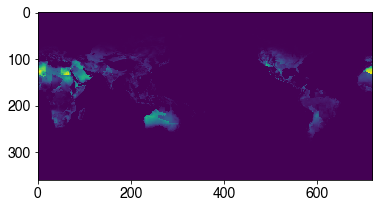

In [390]:
plt.imshow(np.nanmean(kdd,axis=2))

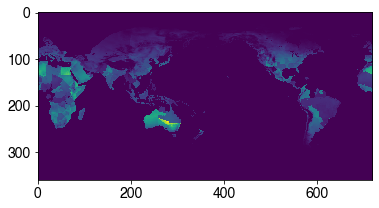

In [391]:
plt.imshow(np.nanmean(gdd,axis=2))

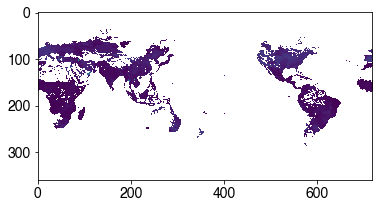

In [393]:
plt.imshow(np.nanmean(maizeYield.Data.values,axis=2))

In [319]:
data = {'GDD':gddAgg, \
        'KDD':kddAgg, \
        'Yield':yieldAgg}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', \
                           'Yield'])
mdl = smf.ols(formula='Yield ~ GDD + KDD', data=df).fit()
mdl.summary()

ValueError: zero-size array to reduction operation maximum which has no identity

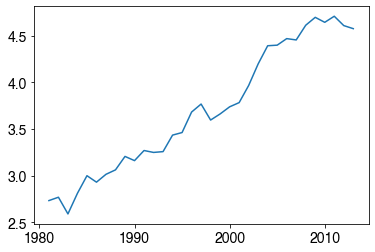

In [34]:
plt.plot(yearRange, np.nanmean(np.nanmean(maizeYield.Data[:,0,:,:], axis=2), axis=1))